In [1]:
from tqdm import tqdm
import torch

import torch_scatter
import torch_geometric
verbose = True

/Users/melkor/miniforge3/envs/Melkor/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /Users/runner/work/pytorch/pytorch/pytorch/aten/src/ATen/native/TensorShape.cpp:3191.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


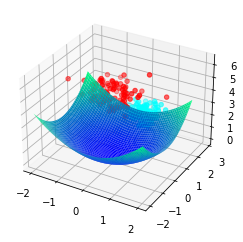

In [2]:
# show some 3d-point cloud data.
import matplotlib.pyplot as plt
from matplotlib import cm
from mpl_toolkits.mplot3d import Axes3D

import numpy as np

fig = plt.figure()
ax = plt.axes(projection = '3d')

scale = 2
x = torch.linspace(-1, 1, 100) * scale
y = torch.linspace(-1, 1, 100) * scale
X,Y = torch.meshgrid(x,y)
Z = X**2 + Y**2 

#ax.plot_surface(X,Y,Z, cmap = "rainbow")

ax.plot_surface(X,Y,Z * 0.5, cmap = "winter")

N = 100
x_points = torch.randn([N, 3]) * 0.5 + torch.tensor([-0.,-0,5]).unsqueeze(0).repeat([N,1])
y_points = torch.randn([N, 3]) * 0.3 + torch.tensor([0.2,2,2]).unsqueeze(0).repeat([N,1])


ax.scatter(x_points[:,0], x_points[:,1], x_points[:,2], color = "red")
ax.scatter(y_points[:,0], y_points[:,1], y_points[:,2], color = "cyan")

plt.show()


/var/folders/tp/c2bzzvd17y35z8x_20mfhn700000gn/T/ipykernel_60994/2308678624.py:13: MatplotlibDeprecationWarning: Axes3D(fig) adding itself to the figure is deprecated since 3.4. Pass the keyword argument auto_add_to_figure=False and use fig.add_axes(ax) to suppress this warning. The default value of auto_add_to_figure will change to False in mpl3.5 and True values will no longer work in 3.6.  This is consistent with other Axes classes.
  ax=Axes3D(fig)


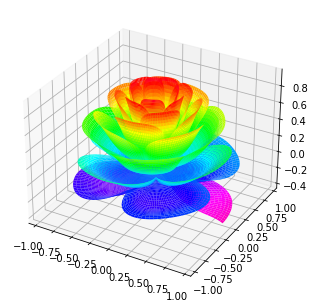

In [3]:
from mpl_toolkits.mplot3d import Axes3D

from matplotlib import cm

from matplotlib.ticker import LinearLocator

import matplotlib.pyplot as plt

import numpy as np

fig=plt.figure()

ax=Axes3D(fig)
#ax = axes3d.Axes3D(fig)

[x,t]=np.meshgrid(np.array(range(25))/24.0,np.arange(0,575.5,0.5)/575*17*np.pi-2*np.pi)

p=(np.pi/2)*np.exp(-t/(8*np.pi))

u=1-(1-np.mod(3.6*t,2*np.pi)/np.pi)**4/2

y=2*(x**2-x)**2*np.sin(p)

r=u*(x*np.sin(p)+y*np.cos(p))

surf=ax.plot_surface(r*np.cos(t),r*np.sin(t),u*(x*np.cos(p)-y*np.sin(p)),rstride=1,cstride=1,cmap=cm.gist_rainbow_r,

                  linewidth=0,antialiased=True)

plt.show()


[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/melkor/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
pybullet build time: Oct 24 2022 03:35:20


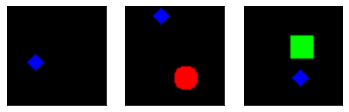

In [4]:
from datasets import *
from models import *
from config import *

node_feat_size = 64
graph_prop_iters = 7
GraphPropagation(num_iters = graph_prop_iters)

grid_convs = RDN(SimpleNamespace(G0=node_feat_size  ,RDNkSize=3,n_colors=3,
                               RDNconfig=(4,3,16),scale=[2],no_upsampling=True))

test_dataset = SpriteData(split = "train")
dataloader = torch.utils.data.DataLoader(test_dataset, batch_size = 3, shuffle = True)

for sample in dataloader:
    ims = sample["image"]
    break;

B, W, H, C = ims.shape
# show the image data to test
plt.figure("input-data", frameon = False,)

for b in range(B):
    plt.subplot(1, B, b + 1);plt.tick_params(left = False, right = False , labelleft = False ,
                labelbottom = False, bottom = False); plt.imshow(ims[b,:,:,:])
plt.show()

In [5]:
imsize = 128
perception_size = 2

# build the connection graph for the grid domain
spatial_edges, spatial_coords = grid(imsize,imsize,device=device)
spaital_edges =  build_perception(imsize,perception_size,device = device)

# flatten the image-feature and add it with the coordinate information
im_feats = grid_convs(ims.permute([0,3,1,2])) # [B,D,W,H]

coords_added_im_feats = im_feats.flatten(2,3).permute(0,2,1) # 【B, N, D】
weights = torch.ones(spatial_edges.shape[1])


graph_in = Batch.from_data_list([Data(x, spatial_edges, edge_attr = {"weights":weights})
                                                for x in coords_added_im_feats])


print(graph_in.x.shape)
print(graph_in.edge_index.shape)
print(graph_in.edge_attr["weights"].shape)


def l2_normalize(x): return torch.nn.functional.normalize(x, p=2.0, dim = -1, eps = 1e-6)

def reduce_max(x, dim, keepdim = True): return torch.max(x, dim = dim, keepdim = keepdim)[0]


torch.Size([49152, 64])
torch.Size([2, 437772])
torch.Size([437772])


In [6]:
import torch
import torch.nn as nn
import torch.nn.functional as F

class ResidualBlock(nn.Module):
    def __init__(self, in_planes, planes, norm_fn='group', kernel_size=3, stride=1, residual=True, bias=True, downsample=False):
        super(ResidualBlock, self).__init__()

        padding = 1 if kernel_size == 3 else 0
        self.conv1 = nn.Conv2d(in_planes, planes, kernel_size=kernel_size, bias=bias, padding=padding, stride=stride)
        self.conv2 = nn.Conv2d(planes, planes, kernel_size=kernel_size, bias=bias, padding=padding)
        self.relu = nn.ReLU(inplace=True)

        num_groups = planes // 8

        if norm_fn == 'group':
            self.norm1 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)
            self.norm2 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)
            if not stride == 1 or downsample is True:
                self.norm3 = nn.GroupNorm(num_groups=num_groups, num_channels=planes)

        elif norm_fn == 'batch':
            self.norm1 = nn.BatchNorm2d(planes)
            self.norm2 = nn.BatchNorm2d(planes)
            if not stride == 1 or downsample is True:
                self.norm3 = nn.BatchNorm2d(planes)

        elif norm_fn == 'instance':
            self.norm1 = nn.InstanceNorm2d(planes)
            self.norm2 = nn.InstanceNorm2d(planes)
            if not stride == 1 or downsample is True:
                self.norm3 = nn.InstanceNorm2d(planes)

        elif norm_fn == 'none':
            self.norm1 = nn.Sequential()
            self.norm2 = nn.Sequential()
            if not stride == 1 or downsample is True:
                self.norm3 = nn.Sequential()

        if stride == 1 and not downsample:
            self.shortcut = None

        else:
            self.shortcut = nn.Sequential(
                nn.Conv2d(in_planes, planes, kernel_size=1, stride=stride, bias=bias), self.norm3)

        self.residual = residual

    def forward(self, x):
        y = x
        y = self.relu(self.norm1(self.conv1(y)))
        y = self.norm2(self.conv2(y))

        if not self.residual:
            return y

        if self.shortcut is not None:
            x = self.shortcut(x)

        return self.relu(x+y)

In [7]:
# [Scene Structure]

def to_base(indices, edges):
    """
    input:
        indices: [K]
        edges: [N,2]
    outputs:
        base_indices: [L]
    """
    base_indices = []
    for i in range(edges.shape[0]): 
        if (edges[i][0] in indices): base_indices.append(i)
    return base_indices

def location_in_node(scene, node):
    return False

class SceneStructure:
    def __init__(self, graph, scores, from_base = None, base = None):
        self.graph = graph
        self.features = graph.x # [N, D]
        self.scores   = scores # [N, 1]
        self.edge_affinities = graph.edge_attr["weights"] #[N, N]
        self.from_base = from_base # [2,N]: [[1, 3],[1, 1]]
        self.base = base # Base Level Scene Structure
    
    def is_base(self): return self.from_base is None

    def locate_in(self, pos, node_indices):return 0

    def compute_masks(self, indices):
         # input: indices of nodes that need to compute mask
         # matrix form version.
        nodes = to_base(indices, self.from_base)
        if self.is_base():return self.scores[nodes]
        return self.base.compute_masks(nodes)

    def sparse_compute_masks(self, indices): 
        # input: indices of nodes that need to compute mask
        nodes = []
        for a in self.from_base.permute([1,0]):
            if a[1] in indices: nodes.append(a[0])
        if self.is_base():
            # this is the base level, just return the corresponding nodes
            return self.scores[nodes]
        return  self.base.compute_masks(nodes)

In [8]:
# may be we need a new graph propagation module

class GraphPropagator(nn.Module):
    def __init__(self, num_iters = 10, excite = True, inhibit = True, project = False, adj_thresh = 0.5):
        super().__init__()
        self.num_iters = num_iters
        self.excite = excite
        self.inhibit = inhibit
        self.project = project
        self.adj_thresh = adj_thresh
    
    @staticmethod
    def _threshold(x, thresh):
        return x * (x > thresh).float()

    @staticmethod
    def _threshold_sparse_tensor(x, thresh):
        row, col, value = x.coo()
        valid = value > thresh
        sparse_size = [x.size(0), x.size(1)]
        output = SparseTensor(row=row[valid],col=col[valid],value=value[valid],sparse_sizes=sparse_size)
        return output

    @staticmethod
    def _projection(v, u, eps=1e-12):
        u_norm = torch.sum(u * u, -1, keepdims=True)
        dot_prod = torch.sum(v * u, -1, keepdims=True)
        proj = (dot_prod / (u_norm + eps)) * u
        return proj

    @staticmethod
    def _relu_norm(x, relu=True, norm=True, eps=1e-16):
        x = F.relu(x) if relu else x
        x = F.normalize(x + eps, p=2.0, dim=-1, eps=max([eps, 1e-12])) if norm else x
        return x

    def forward(self, state, edge_index, edge_attrs):
        state
        return state

    def propagate_step(self, state, h_e, h_i):
        return 0

In [9]:
from torch.nn import Linear, Parameter
from torch_geometric.nn import MessagePassing
from torch_geometric.utils import add_self_loops, degree

class GCNConv(MessagePassing):
    def __init__(self, in_channels, out_channels):
        super().__init__(aggr='add')  # "Add" aggregation (Step 5).
        self.lin = Linear(in_channels, out_channels, bias=False)
        self.bias = Parameter(torch.Tensor(out_channels))

        self.reset_parameters()

    def reset_parameters(self):
        self.lin.reset_parameters()
        self.bias.data.zero_()

    def forward(self, x, edge_index):
        # x has shape [N, in_channels]
        # edge_index has shape [2, E]

        # Step 1: Add self-loops to the adjacency matrix.
        edge_index, _ = add_self_loops(edge_index, num_nodes=x.size(0))

        # Step 2: Linearly transform node feature matrix.
        x = self.lin(x)

        # Step 3: Compute normalization.
        row, col = edge_index
        deg = degree(col, x.size(0), dtype=x.dtype)
        deg_inv_sqrt = deg.pow(-0.5)
        deg_inv_sqrt[deg_inv_sqrt == float('inf')] = 0
        norm = deg_inv_sqrt[row] * deg_inv_sqrt[col]

        # Step 4-5: Start propagating messages.
        out = self.propagate(edge_index, x=x, norm=norm)

        # Step 6: Apply a final bias vector.
        out += self.bias

        return out

    def message(self, x_j, norm):
        # x_j has shape [E, out_channels]

        # Step 4: Normalize node features.
        return norm.view(-1, 1) * x_j

In [10]:
# write some util functions

import numpy as np

def sample_indices(batch, size, k_samples):
    max_index = size[0] * size[1]
    sample_index = []
    for b in range(batch):
        for k in range(k_samples): sample_index.append(\
            np.random.randint(max_index*b, max_index*(b+1)))
    return sample_index

def fully_connected(size = 4):
    full_edges = []
    for i in range(size):
        for j in range(size):full_edges.append([i,j])
    full_edges = torch.tensor(full_edges).t()
    return full_edges

# [Node Extraction]

class NodeExtraction(nn.Module):
    def __init__(self, k_nodes = 5, grid_size = (128,128)):
        super().__init__()
        self.k_nodes = k_nodes
        self.grid_size = grid_size

    def forward(self,state, scene):
        """
        input: scene structure with
            x: node features [N, D]
            from_base: connection to the lower level
            locate_in(loc, node) -> bool
        output: at most k nodes from the 
        """
        node_features = state #[N,D]
        batch_size = scene.graph.batch.max() + 1
        sample_index = sample_indices(batch_size, size = self.grid_size, k_samples = self.k_nodes)
        sample_features = node_features[sample_index]
        print("location_feature_heads: ", sample_features.shape)
        print("node_features:", node_features.shape)
        masks = torch.einsum("nd,md->nm", sample_features, node_features)
        print("masks:",masks.shape)

        return masks

if 1:
    print("test utility of the node extraction")
    indices = sample_indices(3, (2,2), 3)
    print(indices)

test utility of the node extraction
[1, 3, 3, 7, 6, 5, 11, 11, 8]


In [11]:
# prototype for the construct quarter
class ConstructQuarter(nn.Module):
    def __init__(self, in_feat_size, out_feat_size, k_nodes = 5):
        super().__init__()
        # [Graph Convolution] for the input data
        self.graph_conv = GCNConv(in_feat_size, out_feat_size)
        self.location_itrs = k_nodes

        # [Affinity Decoder] softversion of graph constructer
        self.k_conv = GCNConv(in_feat_size, out_feat_size)
        self.q_conv = GCNConv(in_feat_size, out_feat_size)

        # [Graph Propagation] create the Graph Propgation Module
        self.graph_propagator = GraphPropagator(num_iters = 7)

        # [Node Extraction]
        self.node_extractor = NodeExtraction(k_nodes = k_nodes)
        
    def forward(self, scene, from_base = False):
        # abstract the input graph data
        if from_base:
            # do not compute affinity graph
            input_graph = scene.graph
            x = input_graph.x
            edge_index = input_graph.edge_index
            edge_weights = input_graph.edge_attr["weights"]
            abstract_features = x
        else:
            # need an extra step to build edges and decode affinities
            # [Abstract]
            edge_index = fully_connected(size = scene.graph.x.shape[0])
            input_graph = scene.graph
            x = input_graph.x
            abstract_features = self.graph_conv(x, edge_index)

            # [Constructe Affinities]
            decode_ks = self.k_conv(x, edge_index)
            decode_qs = self.q_conv(x, edge_index)
            # build affinities
            print(decode_ks.shape)
            weights = torch.cosine_similarity(
            decode_ks[:,edge_index[0,:]],decode_qs[:,edge_index[1,:]],
             dim = -1)
            weights = torch_scatter.scatter_softmax(weights, edge_index[1,:]) # softmax((Wfi).(Wfj))
            weights = weights / torch.max(weights,edge_index[1,:])
            if verbose:
                print("start the Graph Convolution")
                print(abstract_features.shape)        
            edge_weights = weights

        # [Propagate]
        # perform propagation over the continuous label on the graph
        print("start the Graph Propagation")
        random_init_state = torch.randn(x.shape) # random initialize labels
        prop_features = self.graph_propagator(random_init_state, edge_index, edge_weights)
        print("prop_features:",prop_features.shape)
        
        # [Extract Nodes]
        # region competition and constuct the nodes at each level.
        masks_extracted = torch.tensor(self.node_extractor(prop_features, scene))
        print(abstract_features.shape, masks_extracted.shape)
        node_features = torch.einsum("nd,mn->md",abstract_features, masks_extracted)
        node_scores = torch.max(masks_extracted, dim = -1).values
        if verbose:
            print("start the Node Extraction")
            print("  masks_extracted:", masks_extracted.shape)
            print("  node_features:", node_features.shape)
            print("  node_scores:", node_scores.shape)
        # TODO: a more complicated node extraction
        output_graph = Batch.from_data_list([Data(node_features, edge_attr={"weights":None})])

        # [Build Abstracted Scene] 
        abstract_scene = SceneStructure(output_graph, node_scores, False, scene)

        return abstract_scene

In [12]:
from config import *

class ConstructNet(nn.Module):
    def __init__(self, config):
        super().__init__()
        self.config = config
        device = config.device
        # construct the grid domain connection
        self.imsize = config.imsize
        self.perception_size = config.perception_size
        # build the connection graph for the grid domain
        spatial_edges, self.spatial_coords = grid(self.imsize,self.imsize,device=device)
        self.spatial_edges =  build_perception(self.imsize,self.perception_size,device = device)
        
        node_feat_size = 64
        # [Grid Convolution]
        self.grid_convs =RDN(SimpleNamespace(G0=node_feat_size  ,RDNkSize=3,n_colors=3,
                               RDNconfig=(4,3,16),scale=[2],no_upsampling=True))
        
        # [Affinity Decoder]
        kq_dim = node_feat_size
        latent_dim = node_feat_size
        norm_fn = "batch"
        kernel_size = 3
        downsample = False
        self.k_convs = nn.Sequential(
            ResidualBlock(kq_dim, latent_dim, norm_fn, kernel_size=kernel_size, bias=False, stride=1, residual=True, downsample=downsample),
            nn.Conv2d(latent_dim, kq_dim, kernel_size=1, bias=True, padding='same'))
        self.q_convs = nn.Sequential(
            ResidualBlock(kq_dim, latent_dim, norm_fn, kernel_size=kernel_size, bias=False, stride=1, residual=True, downsample=downsample),
            nn.Conv2d(latent_dim, kq_dim, kernel_size=1, bias=True, padding='same'))

        # [Construct Quarters]
        construct_config = (10,5)
        self.construct_quarters = nn.ModuleList(
            [ConstructQuarter(node_feat_size, node_feat_size, k) for k in construct_config]
        )

        self.verbose = True

    def forward(self, ims):
        # flatten the image-feature and add it with the coordinate information
        B, W, H, C = ims.shape
        if self.verbose:
            print("input_image:\n  {}x{}x{}x{} #BxWxHxC".format(*list(ims.shape)))
        im_feats = self.grid_convs(ims.permute([0,3,1,2])) # [B,D,W,H]

        # [Image Grid Convolution]
        coords_added_im_feats = im_feats.flatten(2,3).permute(0,2,1) # 【B, N, D】
        weights = torch.ones(self.spatial_edges.shape[1]) # []

        # [Affinity Decoder](base)
        edges = self.spatial_edges
        decode_ks = self.k_convs(im_feats).flatten(2,3).permute(0,2,1)
        decode_qs = self.q_convs(im_feats).flatten(2,3).permute(0,2,1)

        weights = torch.cosine_similarity(
            decode_ks[:,edges[0,:],:],decode_qs[:,edges[1,:],:],
             dim = -1)
        weights = torch_scatter.scatter_softmax(weights, edges[1,:]) # softmax((Wfi).(Wfj))
        weights = weights / torch.max(weights,edges[1,:])
        # TODO: scatter normalize the graph weight

        # [Base Graph] construct the initial spatial-augumented graph input        
        graph_in = Batch.from_data_list([
            Data(coords_added_im_feats[i], self.spatial_edges, edge_attr = {"weights":weights[i]})
                                                for i in range(B)])

        if self.verbose:
            print("input_graph:\n x: {}x{} #NxD \n  batch: {} bn:{}\n  edge_indices: {}x{}\n  edge_weight: {}".format(
                *list(graph_in.x.shape), *list(graph_in.batch.shape), graph_in.batch.max()+1,
                *list(graph_in.edge_index.shape), *list(graph_in.edge_attr["weights"].shape)
                ))
            print("  weight specs: max:{} min:{}".format(graph_in.edge_attr["weights"].max(), graph_in.edge_attr["weights"].min()))

        # [Construct Quarter] 
        # create the abstracted graph at each level and construct the scene parse tree
        input_graph = graph_in
        construct_counter = 0
        # base level scene structure
        base_scene_structure = SceneStructure(input_graph,\
            scores = torch.ones(weights.shape), from_base = None, base = None)
        curr_scene = base_scene_structure
        from_base = True
        if self.verbose:
            print("scene construction::\n")
        for construct_quarter in self.construct_quarters:
            construct_counter +=1
            if self.verbose:
                print("construct quarter {}:".format(construct_counter))
            curr_scene = construct_quarter(curr_scene, from_base)
            from_base = False
            # load the abstract graph information
            if self.verbose:
                print("")
        return ims

In [13]:
construct_net = ConstructNet(config)

outputs = construct_net(ims)

input_image:
  3x128x128x3 #BxWxHxC
input_graph:
 x: 49152x64 #NxD 
  batch: 49152 bn:3
  edge_indices: 2x1205868
  edge_weight: 1205868
  weight specs: max:1.0 min:2.1794328404212138e-06
scene construction::

construct quarter 1:
start the Graph Propagation
prop_features: torch.Size([49152, 64])
location_feature_heads:  torch.Size([30, 64])
node_features: torch.Size([49152, 64])
masks: torch.Size([30, 49152])
torch.Size([49152, 64]) torch.Size([30, 49152])
start the Node Extraction
  masks_extracted: torch.Size([30, 49152])
  node_features: torch.Size([30, 64])
  node_scores: torch.Size([30])

construct quarter 2:
torch.Size([30, 64])


/var/folders/tp/c2bzzvd17y35z8x_20mfhn700000gn/T/ipykernel_60994/1957031476.py:60: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  masks_extracted = torch.tensor(self.node_extractor(prop_features, scene))


RuntimeError: The expanded size of the tensor (30) must match the existing size (900) at non-singleton dimension 0.  Target sizes: [30].  Tensor sizes: [900]